In [21]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data.sampler import SubsetRandomSampler
# device = torch.device("cuda") if
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, path, normalize=False, remove_zeros=False):
        super().__init__()
        self.path = path
        self.data = pd.read_csv(path)
        if remove_zeros:
            self.data = self.data[(self.data[["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]] != 0).all(axis=1)]
        self.X = self.data.drop('Outcome', axis=1).to_numpy()
        self.y = self.data['Outcome'].to_numpy()
        self.features = self.X.shape[1]

        if normalize:
            self.X = MinMaxScaler().fit_transform(self.X)
        

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.data)


In [3]:
ds = Dataset("diabetes.csv", normalize=True)

validation_split = .1
dataset_size = len(ds)
print(str(dataset_size) + " rows")
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

dataloader_train = torch.utils.data.DataLoader(ds, batch_size=10, num_workers=4, sampler=train_sampler)
dataloader_val = torch.utils.data.DataLoader(ds, batch_size=10, num_workers=4, sampler=valid_sampler)

input_size = ds.features

768 rows


In [23]:
class Model(torch.nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()

        self.seq = torch.nn.Sequential(

            torch.nn.Linear(in_size, 16),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(16, 8),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(8, out_size)
        )

    def forward(self,x):
        out = self.seq(x)
        return out
        

In [24]:
model = Model(input_size, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
loss_function = torch.nn.CrossEntropyLoss()

In [69]:
def train_loop(model, train_dl, val_dl ,device, epochs=50, tolerance=1e-3, early_stop=True):
    model = model.to(device)
    hist = {}

    train_loss ={}
    val_loss = {}

    train_acc = {}
    val_acc = {}

    best_loss = np.inf
    loop = tqdm(range(epochs))
    
    for epoch in loop:
        losses = []
        accs = []
        model.train()
        for batch in train_dl:
            X, y = batch[0].float(), batch[1].long()
            
            y_hat = model(X)
            loss = loss_function(y_hat, y)
            losses.append(loss.item())
            model.zero_grad()
            loss.backward()
            optimizer.step()
            prediction = y_hat.argmax(1)
            acc = (prediction == y).sum()/len(y)
            accs.append(acc)
            
        losses_val = []
        accs_val= []
        model.eval()
        with torch.no_grad():
            for batch in val_dl:
                X, y = batch[0].float(), batch[1].long()
                y_hat = model(X).detach().cpu()
                loss = loss_function(y_hat, y)
                losses_val.append(loss.item())
                prediction = y_hat.argmax(1)
                acc = (prediction == y).sum()/len(y)
                accs_val.append(acc)
        loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(loss = round(np.mean(losses),3), val_loss = round(np.mean(losses_val), 3))
        # print(f"Epoch: {epoch+1} acc {np.mean(accs):.3f} loss {np.mean(losses):.3f} Val: acc{np.mean(val_accs):.3f} loss {np.mean(val_losses):.3f}")
        train_loss.update({epoch: np.mean(losses)})
        val_loss.update({epoch: np.mean(losses_val)})
        train_acc.update({epoch: np.mean(accs)})
        val_acc.update({epoch: np.mean(accs_val)})
        # Early stopping
        if early_stop:
            if abs(best_loss -  np.mean(losses_val)) < tolerance:
                print(f"At Epoch {epoch+1} the model obtained the best results. Stopping")
                break
            else:
                best_loss =  np.mean(losses_val)
        hist = {"epoch": epoch+2}


    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 10))
    ax0.plot(train_loss.keys(), train_loss.values(),'r')
    ax0.plot(val_loss.keys(), val_loss.values())
    ax0.legend(['train', 'val'])
    ax0.title.set_text("Loss")
    ax1.plot(train_acc.keys(), train_acc.values(),'r')
    ax1.plot(val_acc.keys(), val_acc.values())
    ax1.legend(['train', 'val'])
    ax1.title.set_text("Acc")
    fig.show()
    return hist

Epoch [37/50]:  72%|███████▏  | 36/50 [00:08<00:03,  4.06it/s, loss=0.647, val_loss=0.679]
/tmp/ipykernel_533249/1617620135.py:69: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


At Epoch 37 the model obtained the best results. Stopping


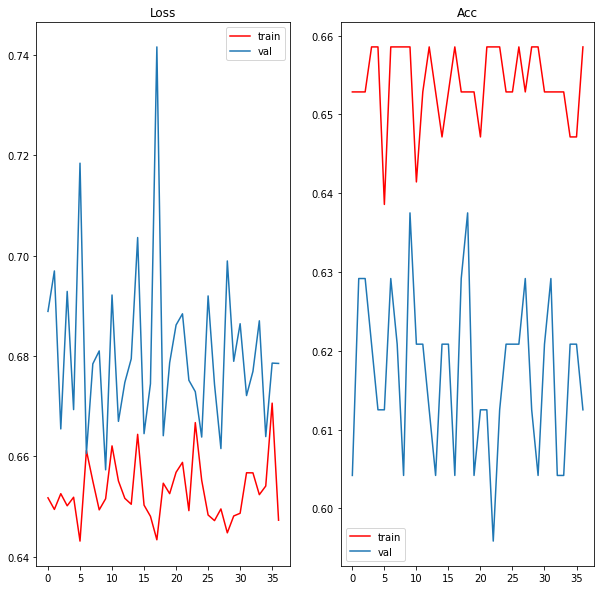

In [70]:
hist = train_loop(model, dataloader_train, dataloader_val, device = device, tolerance=0.001)

Epoch [37/37]: 100%|██████████| 37/37 [00:08<00:00,  4.26it/s, loss=0.648, val_loss=0.675]
/tmp/ipykernel_533249/1617620135.py:69: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'epoch': 38}

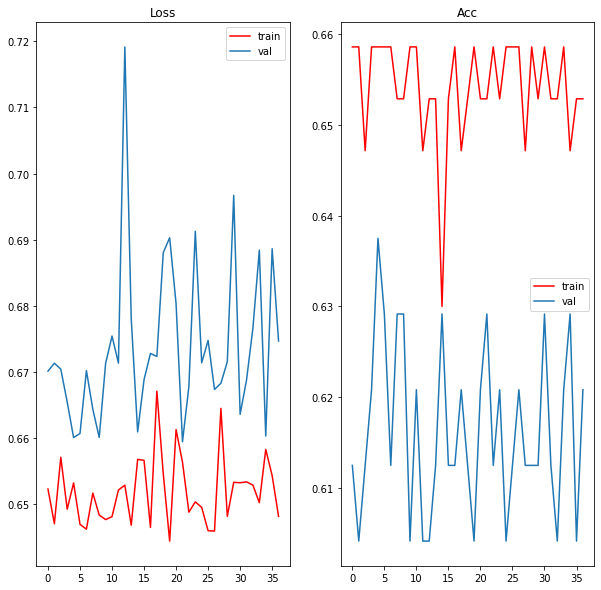

In [71]:
train_loop(model, dataloader_train, dataloader_val, device = device, epochs=hist['epoch'], early_stop=False)